<a href="https://colab.research.google.com/github/koya75/Honda/blob/master/2SpringSeminar_PyTorch1_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 春の勉強会 (PyTorch1)

## モジュールの呼び出し

In [ ]:
import numpy as np
import argparse
import sys

import urllib
import zipfile
import os

import torch
import torch.nn as nn #計算グラフの構築に使用
import torch.optim as optim #最適化アルゴリズム
import torchsummary #特徴マップのサイズ確認
import torchvision #機械学習のフレームワーク
import torchvision.transforms as transform #画像変換
from torch.utils.data import DataLoader, Dataset #Detaloader
from torchvision.datasets import MNIST
from torch.autograd import Variable #自動で微分

## モデルクラスの定義

In [ ]:
class NN(nn.Module):
    def __init__(self,in_size,hidden_size,out_size):
        super(NN,self).__init__()
        self.xh = nn.Linear(in_size,hidden_size) #全結合層
        #self.xh2 = nn.Linear(hidden_size,hidden_size)　課題1
        self.ho = nn.Linear(hidden_size,out_size) #全結合層
        self.act = nn.ReLU() #ReLU関数
        self.softmax = nn.Softmax(dim=1)
    def forward(self,x,train=False):
        x = x.view(-1,28*28) #28*28に調整
        h = self.act(self.xh(x))
        #h = self.act(self.xh2(h))　課題1
        y = self.act(self.ho(h))
        if train:
            return y
        return self.softmax(y)

## パラメータの設定

In [ ]:
parser=argparse.ArgumentParser()
parser.add_argument('--epoch',type=int,default=20,help='number of epoch')
parser.add_argument('--in_size',type=int,default=784,help='input size')
parser.add_argument('--hidden_size',type=int,default=50,help='hidden size')
parser.add_argument('--out_size',type=int,default=10,help='output size')
parser.add_argument('--batch_size',type=int,default=32,help='number of batch size')
parser.add_argument('--lr',type=float,default=0.03,help='number of learning rate')
args=parser.parse_args(args=[])

## データセットのダウンロード

足立先輩のdropboxからMNISTをダウンロード


In [ ]:
class MNIST_Loader(Dataset):
  def __init__(self, train=True, download=True, transform=None):
    self.transform = transform
    self.url = 'https://www.dropbox.com/s/hc7ukm7vzst5e40/MNIST.zip?dl=1'
    
    if download:
      self._download()
    
    dname = os.path.join(self.url.rpartition('/')[2][:-9], 'processed')
    if train:
      datapath = os.path.join(dname, 'training.pt')
    else:
      datapath = os.path.join(dname, 'test.pt')
  
    self.data = torch.load(datapath)

  def __len__(self):
    return len(self.data[0])

  def _download(self):
    filename = self.url.rpartition('/')[2][:-5]
    urllib.request.urlretrieve(self.url, filename)

    with zipfile.ZipFile(filename) as existing_zip:
      existing_zip.extractall()
    os.remove(filename)

  def __getitem__(self, i):
    image = transform.ToPILImage()(self.data[0][i])
    label = self.data[1][i]

    if self.transform:
      image = self.transform(image)
    return image, label

In [ ]:
try:
  mnist_data = MNIST(root='./data', train=True, transform=transform.ToTensor(), download=True)
except: #例外処理
  print('Warning: Switch the original implementation because official MNIST data did not download (probably the official server has down).')
  mnist_data = MNIST_Loader(train=True, download=True, transform=transform.ToTensor())
print('Done!')


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 学習用データと評価用データを用意

In [ ]:
train_loader=DataLoader(mnist_data,batch_size=args.batch_size,shuffle=True)
test_loader=DataLoader(mnist_data,batch_size=1,shuffle=True)

## モデルの読み込み

In [ ]:
model=NN(args.in_size,args.hidden_size,args.out_size)

In [ ]:
torchsummary.summary(model, (1,28,28)) #確認用

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]          39,250
              ReLU-2                   [-1, 50]               0
            Linear-3                   [-1, 10]             510
              ReLU-4                   [-1, 10]               0
           Softmax-5                   [-1, 10]               0
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


## 損失関数と最適化手法の定義

In [ ]:
criterion = nn.CrossEntropyLoss() #損失関数をCross Entropyに設定
optimizer = optim.SGD(model.parameters(),lr=args.lr) #SGDに設定
#optimizer = optim.Adam(model.parameters(),lr=args.lr)　課題2

## 学習&評価用コード

In [ ]:
for epoch in range(args.epoch):
    run_loss=0
    correct=0
    total=0
    for i,data in enumerate(train_loader):
        inputs,labels=data
        inputs,labels=Variable(inputs),Variable(labels)
        optimizer.zero_grad()
        outputs=model(inputs,train=True)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        run_loss+=loss.item()
        if i==len(train_loader)-1:
            print('%d loss:%.7f'%(epoch+1,run_loss/len(train_loader)))
            run_loss=0
    for i,data in enumerate(test_loader):
        inputs,labels=data
        inputs,labels=Variable(inputs),Variable(labels)
        outputs=model(inputs,train=False)
        predicted=torch.argmax(outputs)
        total+=labels.size(0)
        correct+=(predicted==labels).sum()
    print("Accuracy %d /%d =%.5f" % (correct,total,float(correct)/total))
    print("========================")

1 loss:0.7007329
Accuracy 54294 /60000 =0.90490
2 loss:0.2977787
Accuracy 55536 /60000 =0.92560
3 loss:0.2454645
Accuracy 56203 /60000 =0.93672
4 loss:0.2101024
Accuracy 56727 /60000 =0.94545
5 loss:0.1841171
Accuracy 57096 /60000 =0.95160
6 loss:0.1638465
Accuracy 57307 /60000 =0.95512
7 loss:0.1475477
Accuracy 57702 /60000 =0.96170
8 loss:0.1340259
Accuracy 57855 /60000 =0.96425
9 loss:0.1232509
Accuracy 58095 /60000 =0.96825
10 loss:0.1144972
Accuracy 58134 /60000 =0.96890
11 loss:0.1065057
Accuracy 58326 /60000 =0.97210
12 loss:0.0996887
Accuracy 58423 /60000 =0.97372
13 loss:0.0935017
Accuracy 58564 /60000 =0.97607
14 loss:0.0885115
Accuracy 58607 /60000 =0.97678
15 loss:0.0839622
Accuracy 58641 /60000 =0.97735
16 loss:0.0797781
Accuracy 58778 /60000 =0.97963
17 loss:0.0757743
Accuracy 58827 /60000 =0.98045
18 loss:0.0724855
Accuracy 58894 /60000 =0.98157
19 loss:0.0689271
Accuracy 58903 /60000 =0.98172
20 loss:0.0664398
Accuracy 59034 /60000 =0.98390


## 分類された画像のプロット

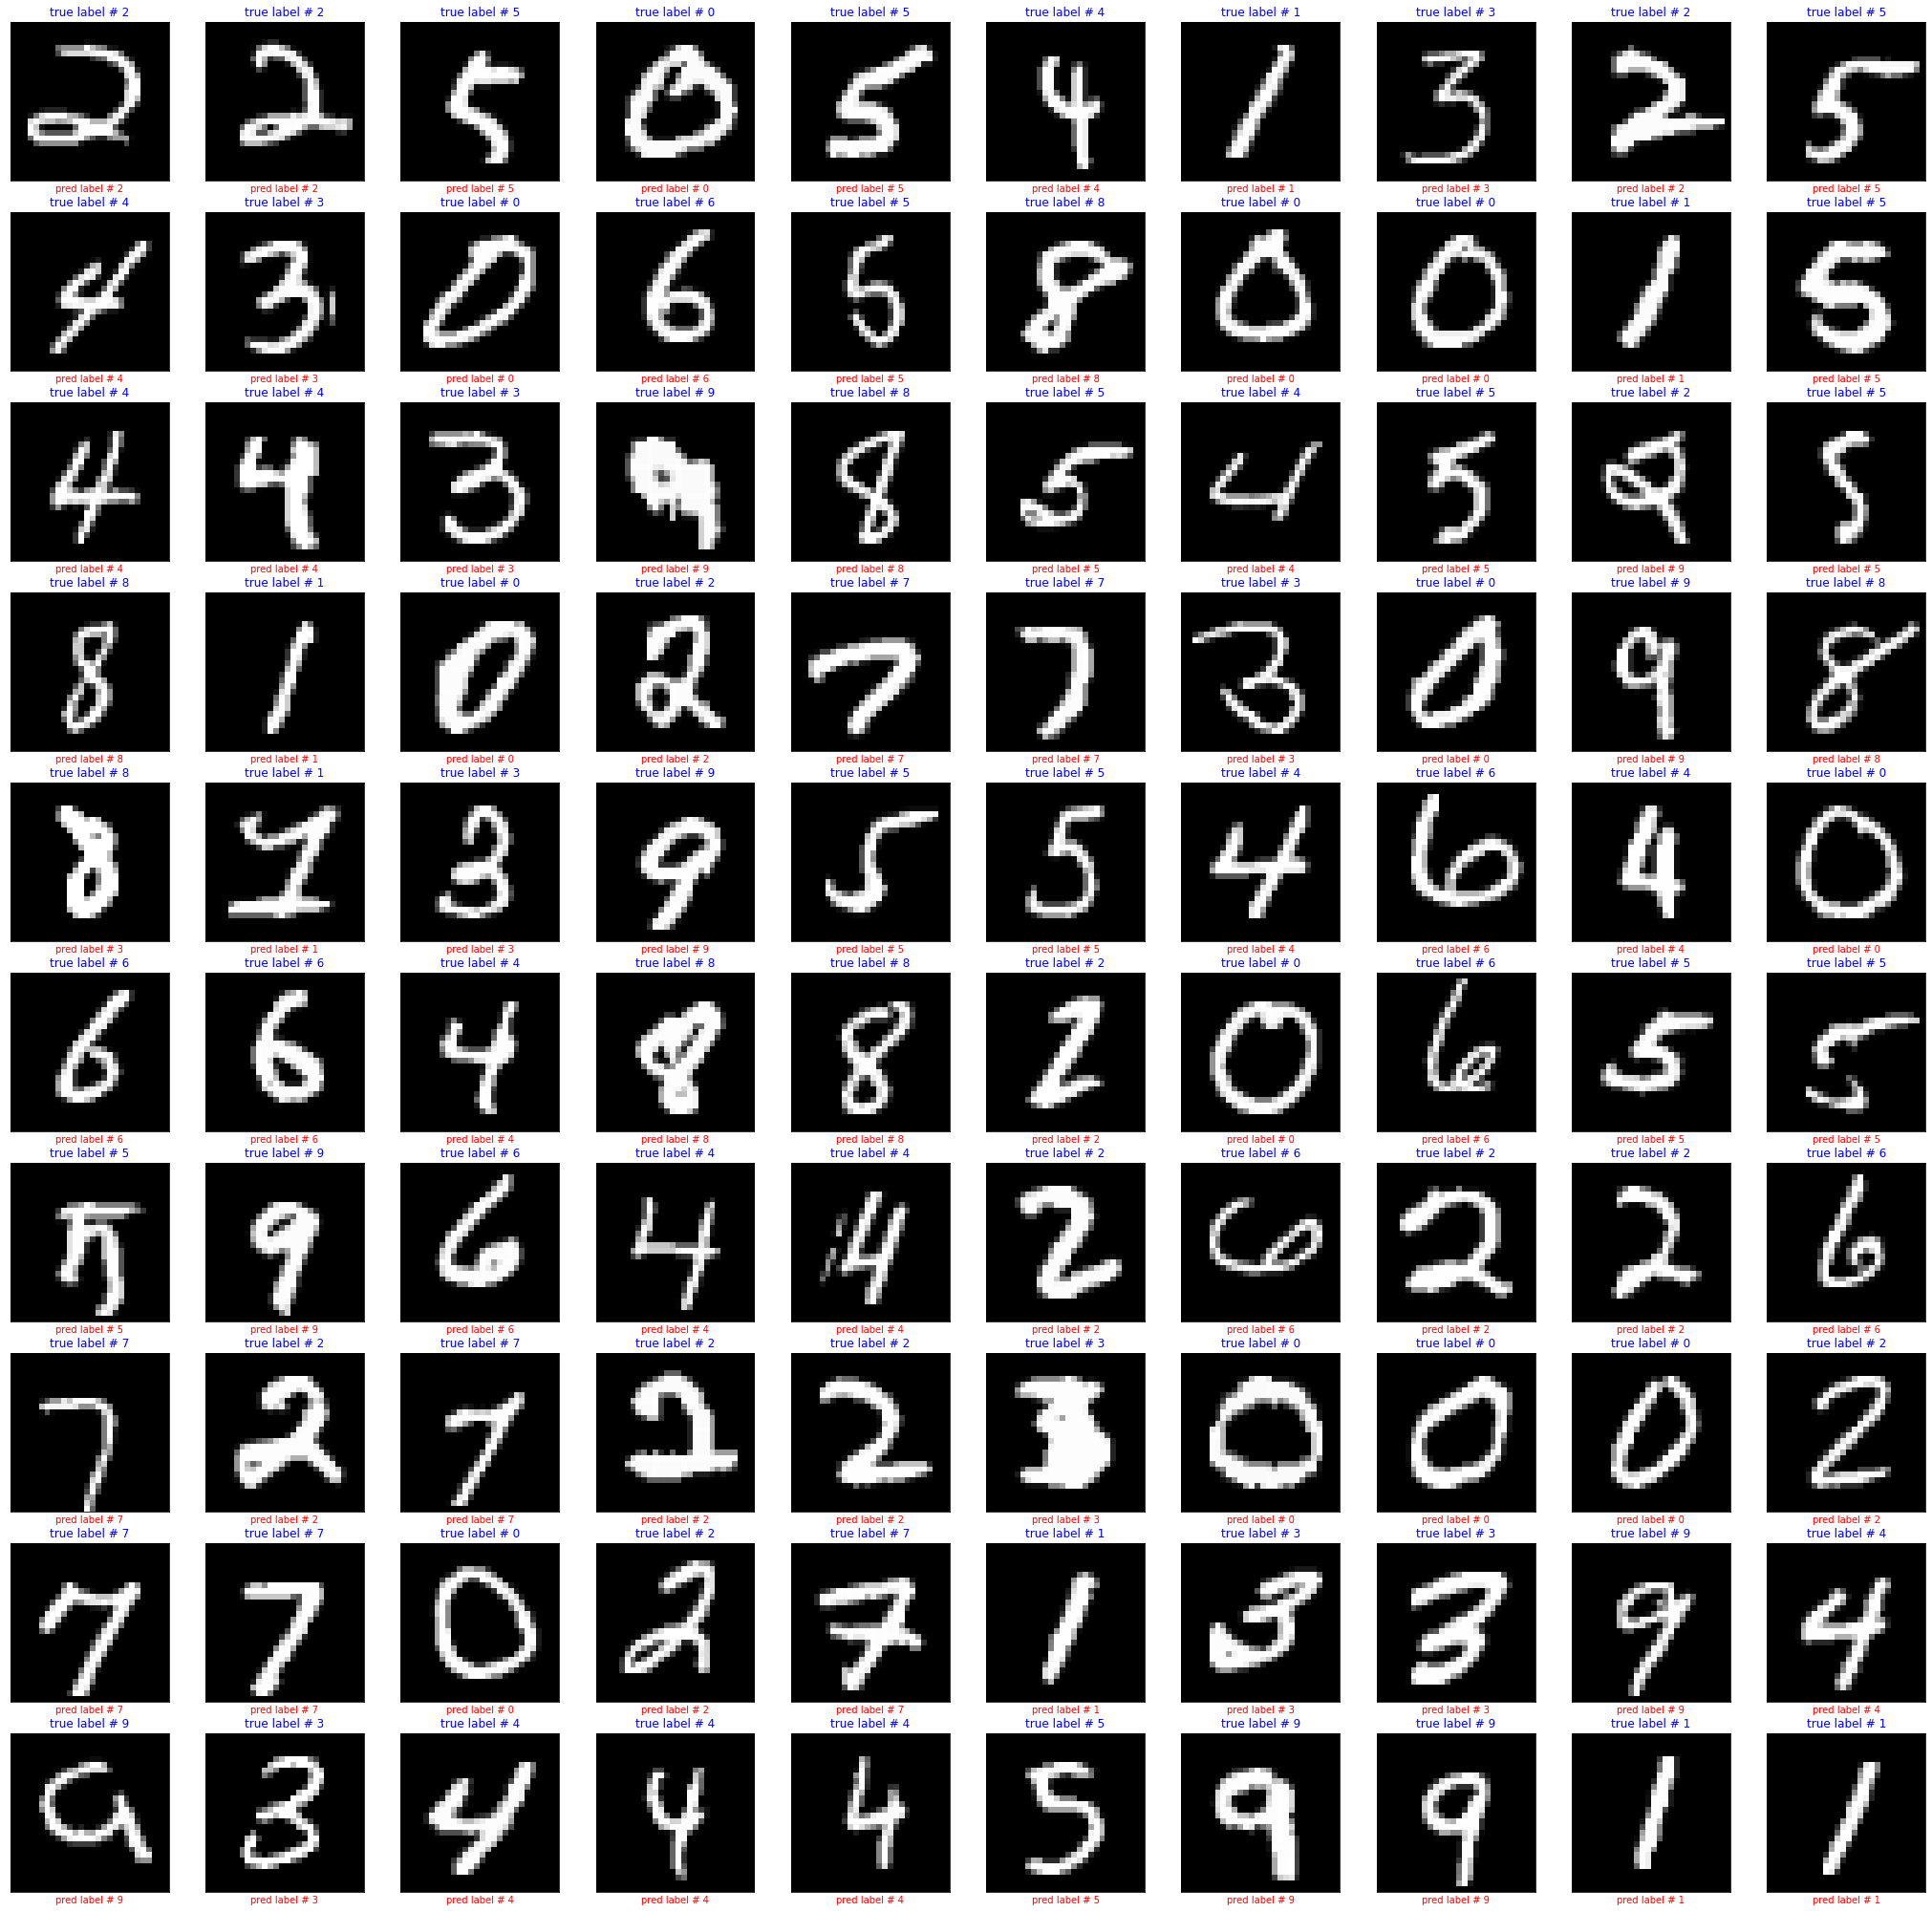

In [ ]:
import matplotlib.pyplot as plt
test_iter=iter(test_loader)

GT_label,P_label,image=[],[],[]
for i in range(100):
    inputs,labels=test_iter.next()
    outputs=model(Variable(inputs))
    _,predicted=torch.max(outputs.data,1)
    GT_label.append(labels[0].numpy().astype(np.int32))
    P_label.append(predicted[0].numpy().astype(np.int32))
    image.append(inputs[0].numpy().reshape(28,28))
    
plt.figure(figsize=[36,36])
for e,(gt,p,i) in enumerate(zip(GT_label,P_label,image)):
    plt.subplot(10,10,e+1)
    plt.imshow(i,cmap='gray') #gray scaleで描画
    plt.xticks([]) #目盛りいらない
    plt.yticks([])
    plt.title("true label # %01d" %gt,c='b') #blueでtrue labelをタイトルとして描画
    plt.xlabel("pred label # %01d" %p,c='r') #redでpred labetをx軸ラベルとして描画